# Exercise: Train a multiple linear regression model
In this exercise, we will train both a simple linear regression model and a multiple linear regresion model, and compare their performance.

## Loading data
Let's start by having a look at our data.

In [10]:
import pandas as pd
import matplotlib.pyplot as graph
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from numpy import reshape, array, meshgrid
import joblib

#Import the data from the .csv file
dataset = pd.read_csv('Data/auto-mpg-cleaned.csv')

#Let's have a look at the data
dataset

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510
1,26.0,4,121.0,113,2234,12.5,70,2,bmw 2002
2,26.0,4,97.0,46,1835,20.5,70,2,volkswagen 1131 deluxe sedan
3,25.0,4,110.0,87,2672,17.5,70,2,peugeot 504
4,25.0,4,104.0,95,2375,17.5,70,2,saab 99e
...,...,...,...,...,...,...,...,...,...
387,27.0,4,112.0,88,2640,18.6,82,1,chevrolet cavalier wagon
388,26.0,4,156.0,92,2585,14.5,82,1,chrysler lebaron medallion
389,25.0,6,181.0,110,2945,16.4,82,1,buick century limited
390,24.0,4,140.0,92,2865,16.4,82,1,ford fairmont futura


For this exercise we will try to predict `mpg` from the other available features. This means that our model will try to find an equation that defines `mpg` as a combination of the remaining 8 features. 

## Data visualization
Let's have a look at how the labels are distributed.

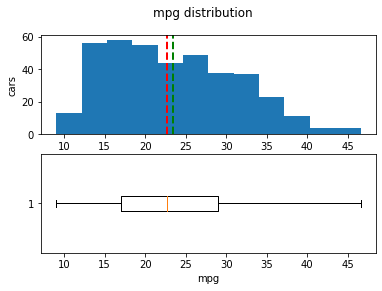

In [2]:
xval = dataset['mpg']

# Create a figure for 2 subplots (2 rows, 1 column)
%matplotlib inline
fig, ax = graph.subplots(2, 1)

# Plot the histogram   
ax[0].hist(xval, bins='auto')
ax[0].set_ylabel('cars')

# Add lines for the mean and median
ax[0].axvline(xval.mean(), color='green', linestyle='dashed', linewidth=2)
ax[0].axvline(xval.median(), color='red', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(xval, vert=False)
ax[1].set_xlabel('mpg')

# Add a title to the Figure
fig.suptitle('mpg distribution')

graph.show()

The locations of the cars' median and mean mpg values tell us that the majority of them have lower mpg. 
Indeed, the only outlier (denoted by a cirle on the boxplot) is a car with an mpg value of over 45.

We can visualize the numerical features of our dataset in a similar manner.

     displacement  horsepower  weight  acceleration  model year
0            97.0          88    2130          14.5          70
1           121.0         113    2234          12.5          70
2            97.0          46    1835          20.5          70
3           110.0          87    2672          17.5          70
4           104.0          95    2375          17.5          70
..            ...         ...     ...           ...         ...
387         112.0          88    2640          18.6          82
388         156.0          92    2585          14.5          82
389         181.0         110    2945          16.4          82
390         140.0          92    2865          16.4          82
391         232.0         112    2835          14.7          82

[392 rows x 5 columns]


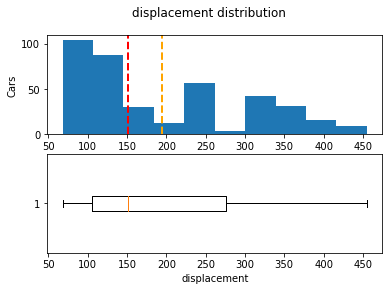

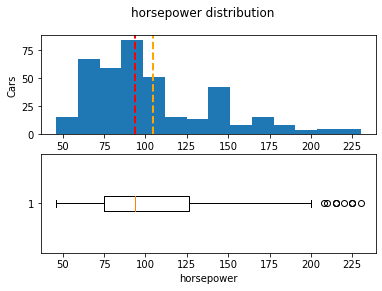

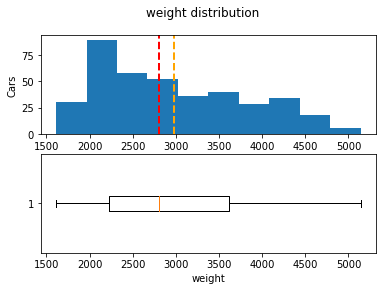

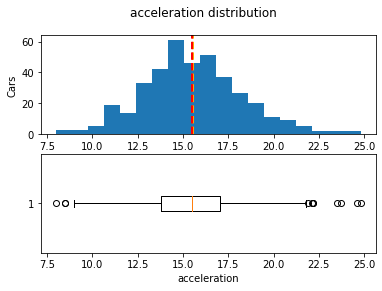

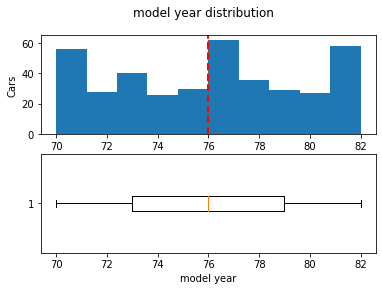

In [3]:
numerical_features = dataset.iloc[:,2:7]
print(numerical_features)
for feature in numerical_features:

    %matplotlib inline

    xval = numerical_features[feature]

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = graph.subplots(2, 1)

    # Plot the histogram   
    ax[0].hist(xval, bins='auto')
    ax[0].set_ylabel('Cars')

    # Add lines for the mean and median
    ax[0].axvline(xval.mean(), color='orange', linestyle='dashed', linewidth=2)
    ax[0].axvline(xval.median(), color='red', linestyle='dashed', linewidth=2)

    # Plot the boxplot   
    ax[1].boxplot(xval, vert=False)
    ax[1].set_xlabel(feature)

    # Add a title to the Figure
    fig.suptitle(str(feature)+' distribution')

    graph.show()

It can also be useful to plot the cars' mpg as a function of each feature, to gain an understanding of how they relate to each other.

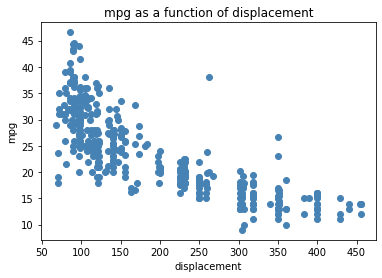

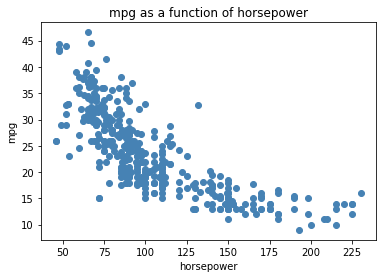

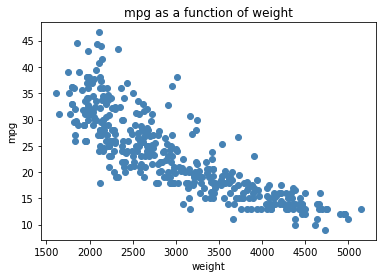

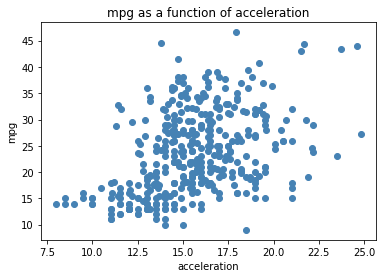

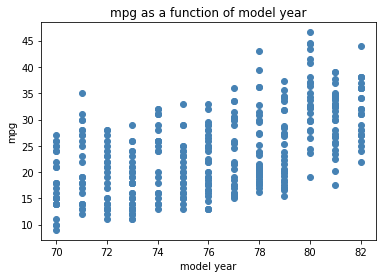

In [4]:
for feature in numerical_features:
    xval = numerical_features[feature]
    yval = dataset['mpg']
    %matplotlib inline
    graph.scatter(xval, yval,  color='steelblue')
    graph.ylabel('mpg')
    graph.xlabel(feature)
    graph.title('mpg as a function of ' + feature)
    graph.show()

We can see that there is either a positive or negative correlation between a car's mpg and each of these numerical features. This makes sense, as we expect newer cars to have a higher mpg, and heavier cars to have a lower mpg for example!

Now, what about the categorical features? Well, with a few changes to our code, we can visualise them too.

     cylinders  origin  car name
0            4       3         0
1            4       2         1
2            4       2         2
3            4       2         3
4            4       2         4
..         ...     ...       ...
387          4       1       296
388          4       1       297
389          6       1       298
390          4       1       299
391          6       1       300

[392 rows x 3 columns]


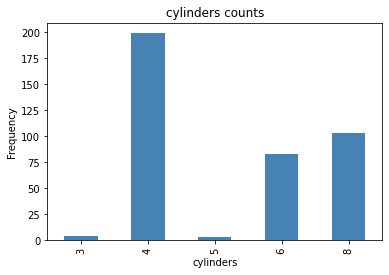

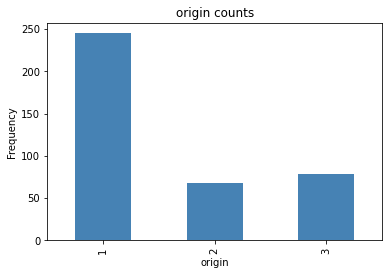

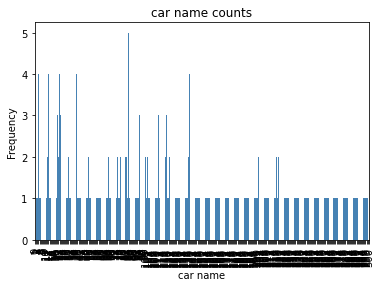

In [5]:
# Let's use pandas' concatenate function to create our categorical features subset
categorical_features = pd.concat([dataset.iloc[:,1],dataset.iloc[:,7:]],axis=1)


# Let's transform the vehicle names into unique integer identifiers for ease of use
unique_car_name = categorical_features['car name'].unique()
car_ids = dict(zip(unique_car_name, range(len(unique_car_name))))
categorical_features['car name'] = categorical_features['car name'].map(car_ids)

print(categorical_features)

for feature in categorical_features:
    
    %matplotlib inline
    xval = categorical_features[feature]    
    counts = xval.value_counts().sort_index()
    fig = graph.figure()
    ax = graph.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(feature + ' counts')
    ax.set_xlabel(feature) 
    ax.set_ylabel("Frequency")

    graph.show()

This tells us that most cars come from a single country, and that the vast majority of cars have got 4-cylinder engines

## Simple linear regression
We've had a look at the data, so now let's create a model that can predict cars' mpg performance. Let's first explore the effect of a single feature, the car's weight, on its mpg performance

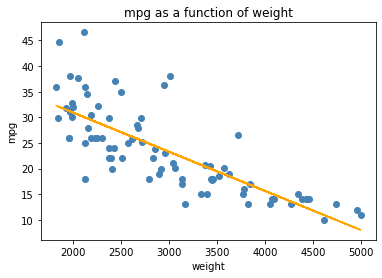

RMSE: 5.160060684030852


['./cars_mpg_weight_model.pkl']

In [6]:
X = array(dataset['weight'])
y = array(dataset['mpg'])

#random_state for reproducibilty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#reshape arrays for 'LinearRegression'

X_train = X_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = LinearRegression().fit(X_train,y_train)

y_pred = model.predict(X_test)

# Show a graph of the result
# Don't worry about how this is done for now
%matplotlib inline
intercept = model.intercept_
slope = model.coef_
line = slope * X_test + intercept
graph.scatter(X_test, y_test,  color='steelblue')
graph.plot(X_test, line, '-', c = 'orange')
graph.ylabel('mpg')
graph.xlabel('weight')
graph.title('mpg as a function of weight')
graph.show()

rms = mean_squared_error(y_test,y_pred, squared=False)
print(f"RMSE: {rms}")

#Let's save this model in case we want to use it later
#Save the model as a pickle file
filename = './cars_mpg_weight_model.pkl'
joblib.dump(model, filename)

## Multiple linear regression
There seems to be a relationship between a car's weight and its mpg performance. Let's see what happens if we include an extra feature into the mix, like its engine displacement

RMSE: 5.138210456138803


['./cars_mpg_weight_displacement_model.pkl']

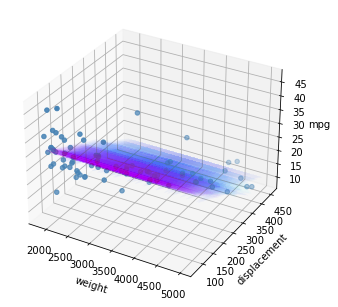

In [7]:
X = array(dataset[['weight','displacement']])
y = array(dataset['mpg'])


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# reshape arrays for 'LinearRegression'
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

model = LinearRegression().fit(X_train,y_train)

y_pred = model.predict(X_test)

# Show a graph of the result
# Don't worry about how this is done for now
%matplotlib inline
fig = graph.figure()
ax = Axes3D(fig)

x_plot = X_test[:,0].flatten()
y_plot = X_test[:,1].flatten()
z_plot = y_test.flatten()

x_grid,y_grid = meshgrid(x_plot,y_plot)
z_grid = y_pred

ax.set_xlabel('weight')
ax.set_ylabel('displacement')
ax.set_zlabel('mpg')

ax.scatter(x_plot,y_plot,z_plot, color='steelblue')
ax.plot_surface(x_grid,y_grid,z_grid, cmap=cm.cool, alpha=0.01)


#TO DO: ADD TITLE TO 3D PLOT

rms = mean_squared_error(y_test,y_pred, squared=False)
print(f"RMSE: {rms}")

#Let's save this model in case we want to use it later
# Save the model as a pickle file
filename = './cars_mpg_weight_displacement_model.pkl'
joblib.dump(model, filename)

The RMSE of this multiple linear regression model is lower than that of the simple linear regression mod. Using multiple features allows to make more accurate predictions when testing a model on unseen data.

## Summary
We covered the following concepts in this exercise:

- Quickly visualize a dataset's labels, numerical, and categorical features.
- Build Single and Multiple Linear Regression Models.
- Compare the performance of both models visually, and as a function of RMSE.